# Machine Learning Engineer Nanodegree
## Capstone Project
## Predicting Ames Houses on the Entire Feature Set

The ultimate goal of this project is to predict how much a house should be solved in Ames, IA.
The problem is a standing [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The dataset contains a list of information for all houses sold in Ames, Iowa from 2006 through 2010. It contains **2930** observations and a large number of explanatory
variables (**23 nominal, 23 ordinal, 14 discrete, and 20 continuous**). Dean De Cook compiled and published this dataset in 2011 and can be found here [here](http://www.amstat.org/publications/jse/v19n3/decock.pdf). 

With the entry Id removed, the dataset is described by 304 features, after transformation of the categoricals to dummy variables.

## I . Import necessary modules.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
 

## II. Load the dataset and drop the unnecessary sample ID.

In [2]:
# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')
data['Age'] = data.YrSold - data.YearBuilt
data['RemodAge'] = data.YrSold - data.YearRemodAdd
data = data.drop(['Id', 'YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1)
data['MSSubClass'] = data['MSSubClass'].astype(int).astype('str')
data = data[data['SalePrice'] <= 400000]
# Success
print "Ames housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.tail(3)

Ames housing dataset has 1432 data points with 79 variables each.
     MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1457         70       RL         66.0     9042   Pave   NaN      Reg   
1458         20       RL         68.0     9717   Pave   NaN      Reg   
1459         20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig   ...    PoolQC  Fence MiscFeature  \
1457         Lvl    AllPub    Inside   ...       NaN  GdPrv        Shed   
1458         Lvl    AllPub    Inside   ...       NaN    NaN         NaN   
1459         Lvl    AllPub    Inside   ...       NaN    NaN         NaN   

     MiscVal MoSold SaleType  SaleCondition  SalePrice Age RemodAge  
1457    2500      5       WD         Normal     266500  69        4  
1458       0      4       WD         Normal     142125  60       14  
1459       0      6       WD         Normal     147500  43       43  

[3 rows x 79 columns]


## III. Define training and preprocessing functions

In [3]:
# Define functions for creating sets and training.
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

############################################## Create Train/Test Splits ##############################################
############################################## Create Train/Test Splits ##############################################

def create_sets(X, y):
    # Split into training and testing components first
    from sklearn.cross_validation import train_test_split, ShuffleSplit
    
    # Set the number of training points
    num_train = int(round(0.90*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test

##############################################   Model   Fitting   ##############################################
##############################################   Model   Fitting   ##############################################

# Using GridSearch CV, we fine tune the model.

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.grid_search import GridSearchCV


def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 6], 'min_samples_leaf':  [2,3,5,9,17]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

In [4]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    conv_col =  ['BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond', 'HeatingQC', 
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        if col in conv_col:
            if col_data.dtype == object:
                col_data = col_data.replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA' ], [9, 7, 5, 3, 2, 0 ]) 
        if col == 'MSSubClass':
            col_data.dtype == object
            
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [5]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(0.)
    print np.shape(df)
    return df

# <center/> IV. Process and Train data.

 ## <center> 4.1 WITH REPEAT OUTLIERS

## 4.1.1 Preprocessing ...

In [6]:
data = remove_nans(data)
y_all =  data['SalePrice'] #in the log
X_all =  data[data.columns[:-1]]
print sorted(X_all.columns)

LotFrontage 257
Alley 1341
MasVnrType 7
MasVnrArea 7
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1426
Fence 1153
MiscFeature 1378
(1432, 79)
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Age', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF'

In [7]:
X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(sorted(X_all.columns)))
print np.shape(X_all)

Processed feature columns (277 total features):
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Age', 'Alley_0.0', 'Alley_Grvl', 'Alley_Pave', 'BedroomAbvGr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond', 'BsmtExposure_0.0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1_0.0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_0.0', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir_N', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 

> ## Feature size ballooned to 304.

## 4.1.2 Investigate learning curves

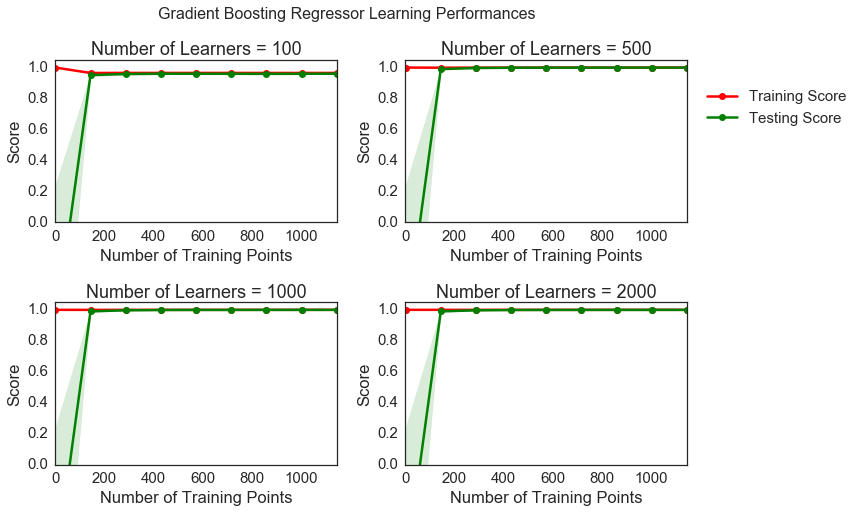

In [8]:
import visuals as vs
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
vs.ModelLearning(X_all, y_all)


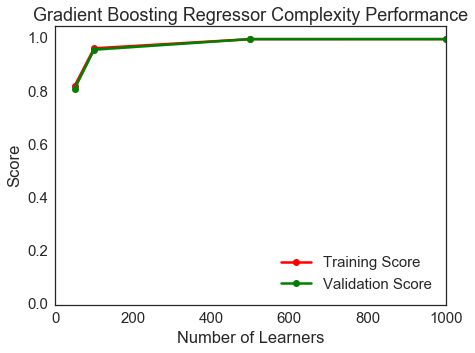

In [ ]:
vs.ModelComplexity(X_all, y_all)

> ### We likely need 1000$^{ish}$ estimators. As before, we use the usual 80-20 split.

## 4.1.3 Begin training the full sample size.

In [ ]:
X_train, X_test, y_train, y_test = create_sets(X_all, y_all)
reg = fit_model(X_train, y_train, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
pred = reg.predict(X_test)
    
print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))

Training set has 1289 samples.
Testing set has 143 samples.


## 4.1.4 Visualize results.

In [ ]:
plt.rcParams["figure.figsize"] = fig_size
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test/1e5, pred/1e5, alpha = 0.5, s = 1000*np.abs(y_test-pred)/y_test, color = 'red')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test/1e5), min(pred/1e5)])-0.5, max([max(y_test/1e5), max(pred)/1e5])+0.5)
plt.ylim(min([min(y_test/1e5), min(pred/1e5)])-0.5, max([max(y_test/1e5), max(pred)/1e5])+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("FinalModel_linear_all.pdf")

In [ ]:
diff = (y_test - pred)/y_test*100.
sns.distplot(diff, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_all.pdf')

In [ ]:
#SECONDARY AXIS WITH COLOR BAR

from scipy import stats

fig = plt.figure()#, figsize=(6,6))
gs = grd.GridSpec(2, 1, height_ratios=[1,15], width_ratios=[20,1], wspace=0.1)

#Primary plot
ax1 = plt.subplot(gs[1])
ax1.hist(y_test, color = ["black"], alpha=0.15)

plt.xlabel(r'House Sale Price [USD]', size=30)
plt.ylabel('Counts', size = 30)


#Secondary AXIS
ax2 = ax1.twinx()
ax2.xaxis.set_minor_locator(minorLocatorx)
ax2.yaxis.set_minor_locator(minorLocatory)

ax2.scatter(y_test, diff,  edgecolor= 'none', s=50, c='red', alpha=0.5)
ax2.set_ylabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);

plt.plot([0, 1e8], [2*np.std(np.abs(diff)),2*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.plot([0, 1e8], [-2*np.std(np.abs(diff)),12*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.ylim(min(diff)-5, max(np.abs(diff))+5)
plt.xlim(min(y_test), max(y_test));
#plt.savefig('Residuals_linear_all.pdf')

In [ ]:
print "The Kaggle log-RMSE is now {:.4f}".format(np.sqrt(np.sum((np.log(y_test +1) - np.log(pred+1))**2)/len(y_test)))

# <center> 4.2 Removing outliers NOW!

### Using [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. 

## 4.2.1 Define function that removes REPEAT outliers. 

Consider as outliers only for those which are continuous variables.

In [ ]:
## Try to remove outliers
# For each feature in out_columns find the data points with extreme high or low values
def remove_outliers(df):
    outliers  = []
    out_columns = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 
                   'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', '1stFlrSF', 
                   "2ndFlrSF", "ScreenPorch", "PoolArea", '3SsnPorch', "MiscVal", "EnclosedPorch",
                   'BsmtFinSF2','LowQualFinSF', "BsmtUnfSF", 'LotFrontage']
    for feature in out_columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 1])
    return outliers

## 4.2.2 Start from a clean slate and then preprocess.

In [ ]:
## Start from a clean slate.
data = pd.read_csv('train.csv')
data = data.drop(['Id'], axis=1)

# Remove NaNs
data_all = remove_nans(data)


# Dummies
data = preprocess_features(data)
print data.shape


# Remove Outliers
outliers = remove_outliers(data)
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
good_data_X = good_data[good_data.columns[:-1]]
good_data_y =  good_data[good_data.columns[-1]]
print "The dimensions of the data without outliers now is {}".format(np.shape(good_data_X))

## 4.2.3 Begin training without outliers

In [ ]:
X_train_good, X_test_good, y_train_good, y_test_good = create_sets(good_data_X, good_data_y)

from time import time
start = time()
reg_good = fit_model(X_train_good, y_train_good, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
end = time()
print "Trained model in {:.4f} seconds".format(end-start)

start = time()
pred_good = reg_good.predict(X_test_good)
end = time()
print "Model made predictions in {:.4f} seconds".format((end-start)/60.)

## 4.2.4 Evaluate, validate and visualize results.

There are 247 examples for testing.

In [ ]:
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_good, y_test_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_good, y_test_good))

In [ ]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test_good/1e5, pred_good/1e5, alpha = 0.5, s = 1000*np.abs(y_test_good-pred_good)/y_test_good, color = 'red')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test_good), min(pred)])/1e5, max([max(y_test_good)-0.5, max(pred_good)])/1e5+0.5)
plt.ylim(min([min(y_test_good), min(pred)])/1e5, max([max(y_test_good)-0.5, max(pred_good)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("FinalModel_linear_all.pdf")

In [ ]:
diff_good = (y_test_good - pred_good)/y_test_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_all.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_good), np.std(diff_good))

## How does the model predict outliers?

In [ ]:
test_data_out = data.iloc[outliers, :]
X_out = test_data_out[test_data_out.columns[:-1]]
y_out = test_data_out[test_data_out.columns[-1]]
X_test_data_out_good = X_out.append(X_test_good, ignore_index=True)
y_test_data_out_good = y_out.append(y_test_good)

print 'The outliers and test set combined has {} examples'.format(len(X_test_data_out_good))

In [ ]:
## Predict the outliers
pred_out = reg_good.predict(X_out)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out, y_out))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out, y_out))

## Predict the test and outliers
pred_out_good = reg_good.predict(X_test_data_out_good)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out_good, y_test_data_out_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out_good, y_test_data_out_good))

## Visualize

In [ ]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test_data_out_good/1e5, pred_out_good/1e5, alpha = 0.5, 
            s = 1000*np.abs(y_test_data_out_good-pred_out_good)/y_test_data_out_good, color = 'blue',
           label ='Test Set')
plt.scatter(y_out/1e5, pred_out/1e5, alpha = 0.5, s = 1000*np.abs(y_out-pred_out)/y_out, color = 'red',
           label ='Outliers Set')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_out), min(pred_out)])/1e5-0.5, max([max(y_out), max(pred_out)])/1e5+0.5)
plt.ylim(min([min(y_out), min(pred_out)])/1e5-0.5, max([max(y_out), max(pred_out)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 'lower right', fontsize=25)
#plt.savefig("FinalModel_linear_out.pdf")

In [ ]:
print 'Kaggle\'s log-RMSE score is {:.6f}'.\
format(np.sqrt(np.sum((np.log(y_test_data_out_good +1) - np.log(pred_out_good+1))**2)/len(y_test_data_out_good)))

In [ ]:
diff_out = (y_test_data_out_good - pred_out_good)/y_test_data_out_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_out.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_out), np.std(diff_out))
diff_out = diff_out.reset_index(drop=True)
X_test_data_out_good.iloc[np.argmin(diff_out),:]

## Now testing on the test.csv set.

In [ ]:
reg2 = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='lad',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)

In [ ]:
reg2.fit(X_train_good, y_train_good)

In [ ]:
pred2 = reg2.predict(X_test_good)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred2, y_test_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred2, y_test_good))

In [ ]:
diff_out = (y_test_good - pred2)/y_test_good*100.
sns.distplot(diff_out, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_out.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_out), np.std(diff_out))

In [ ]:
#SECONDARY AXIS WITH COLOR BAR

from scipy import stats

fig = plt.figure()#, figsize=(6,6))
gs = grd.GridSpec(2, 1, height_ratios=[1,15], width_ratios=[20,1], wspace=0.1)

#Primary plot
ax1 = plt.subplot(gs[1])
ax1.hist(y_test_good, color = ["black"], alpha=0.15)

plt.xlabel(r'House Sale Price [USD]', size=30)
plt.ylabel('Counts', size = 30)


#Secondary AXIS
ax2 = ax1.twinx()
ax2.xaxis.set_minor_locator(minorLocatorx)
ax2.yaxis.set_minor_locator(minorLocatory)

ax2.scatter(y_test_good, diff_out,  edgecolor= 'none', s=50, c='red', alpha=0.5)
ax2.set_ylabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);

plt.plot([0, 1e8], [2*np.std(np.abs(diff_out)),2*np.std(np.abs(diff_out))], color = 'green', linestyle = '--')
plt.plot([0, 1e8], [-2*np.std(np.abs(diff_out)),12*np.std(np.abs(diff_out))], color = 'green', linestyle = '--')
plt.ylim(min(diff_out)-5, max(np.abs(diff_out))+5)
plt.xlim(min(y_test_good), max(y_test_good));
#plt.savefig('Residuals_linear_all.pdf')

In [ ]:
feature_importance = reg2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_test_good.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
imp_feat = X_test_good.columns[sorted_idx[0:219]]

In [ ]:
imp_feat